In [1]:
import pymc as pm
from mc import *
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import arviz as az

In [2]:
%load_ext watermark
az.style.use("arviz-darkgrid")

In [3]:
out_path = f'out/dy_free'
os.makedirs(out_path, exist_ok=True)

src = load_objectives(
    path_data='data/pars.json', 
    path_target='data/targets.json'
)

In [4]:
model = src.build_model()

In [5]:
with model:
    fit = pm.sample_smc(draws=500, chains=3)
    ppost = pm.sample_posterior_predictive(fit)

Initializing SMC sampler...
Sampling 3 chains in 3 jobs


We recommend running at least 4 chains for robust computation of convergence diagnostics


In [6]:
az.summary(fit, kind="stats")

,mean,sd,hdi_3%,hdi_97%
p_comorb,0.363,0.078,0.226,0.487
rr_risk_comorb,17.963,6.057,8.039,28.584
beta_ds,9.661,2.332,5.816,13.890
rr_beta_dr,1.063,0.024,1.019,1.097
rr_inf_asym,0.452,0.214,0.100,0.855
rr_inf_sn,0.201,0.055,0.115,0.295
red_sus,0.198,0.028,0.154,0.245
rr_sus_ltbi,0.200,0.027,0.155,0.246
r_relapse_td,0.142,0.014,0.119,0.168
r_relapse_tc,0.032,0.003,0.027,0.038


array([[<AxesSubplot:title={'center':'p_comorb'}>,
        <AxesSubplot:title={'center':'p_comorb'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'rr_risk_comorb'}>,
        <AxesSubplot:title={'center':'rr_risk_comorb'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'beta_ds'}>,
        <AxesSubplot:title={'center':'beta_ds'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'rr_beta_dr'}>,
        <AxesSubplot:title={'center':'rr_beta_dr'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'rr_inf_asym'}>,
        <AxesSubplot:title={'center':'rr_inf_asym'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'rr_inf_sn'}>,
        <AxesSubplot:title={'center':'rr_inf_sn'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'red_sus'}>,
        <AxesSubplot:title={'center':'red_sus'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'rr_sus_ltbi'}>,
        <

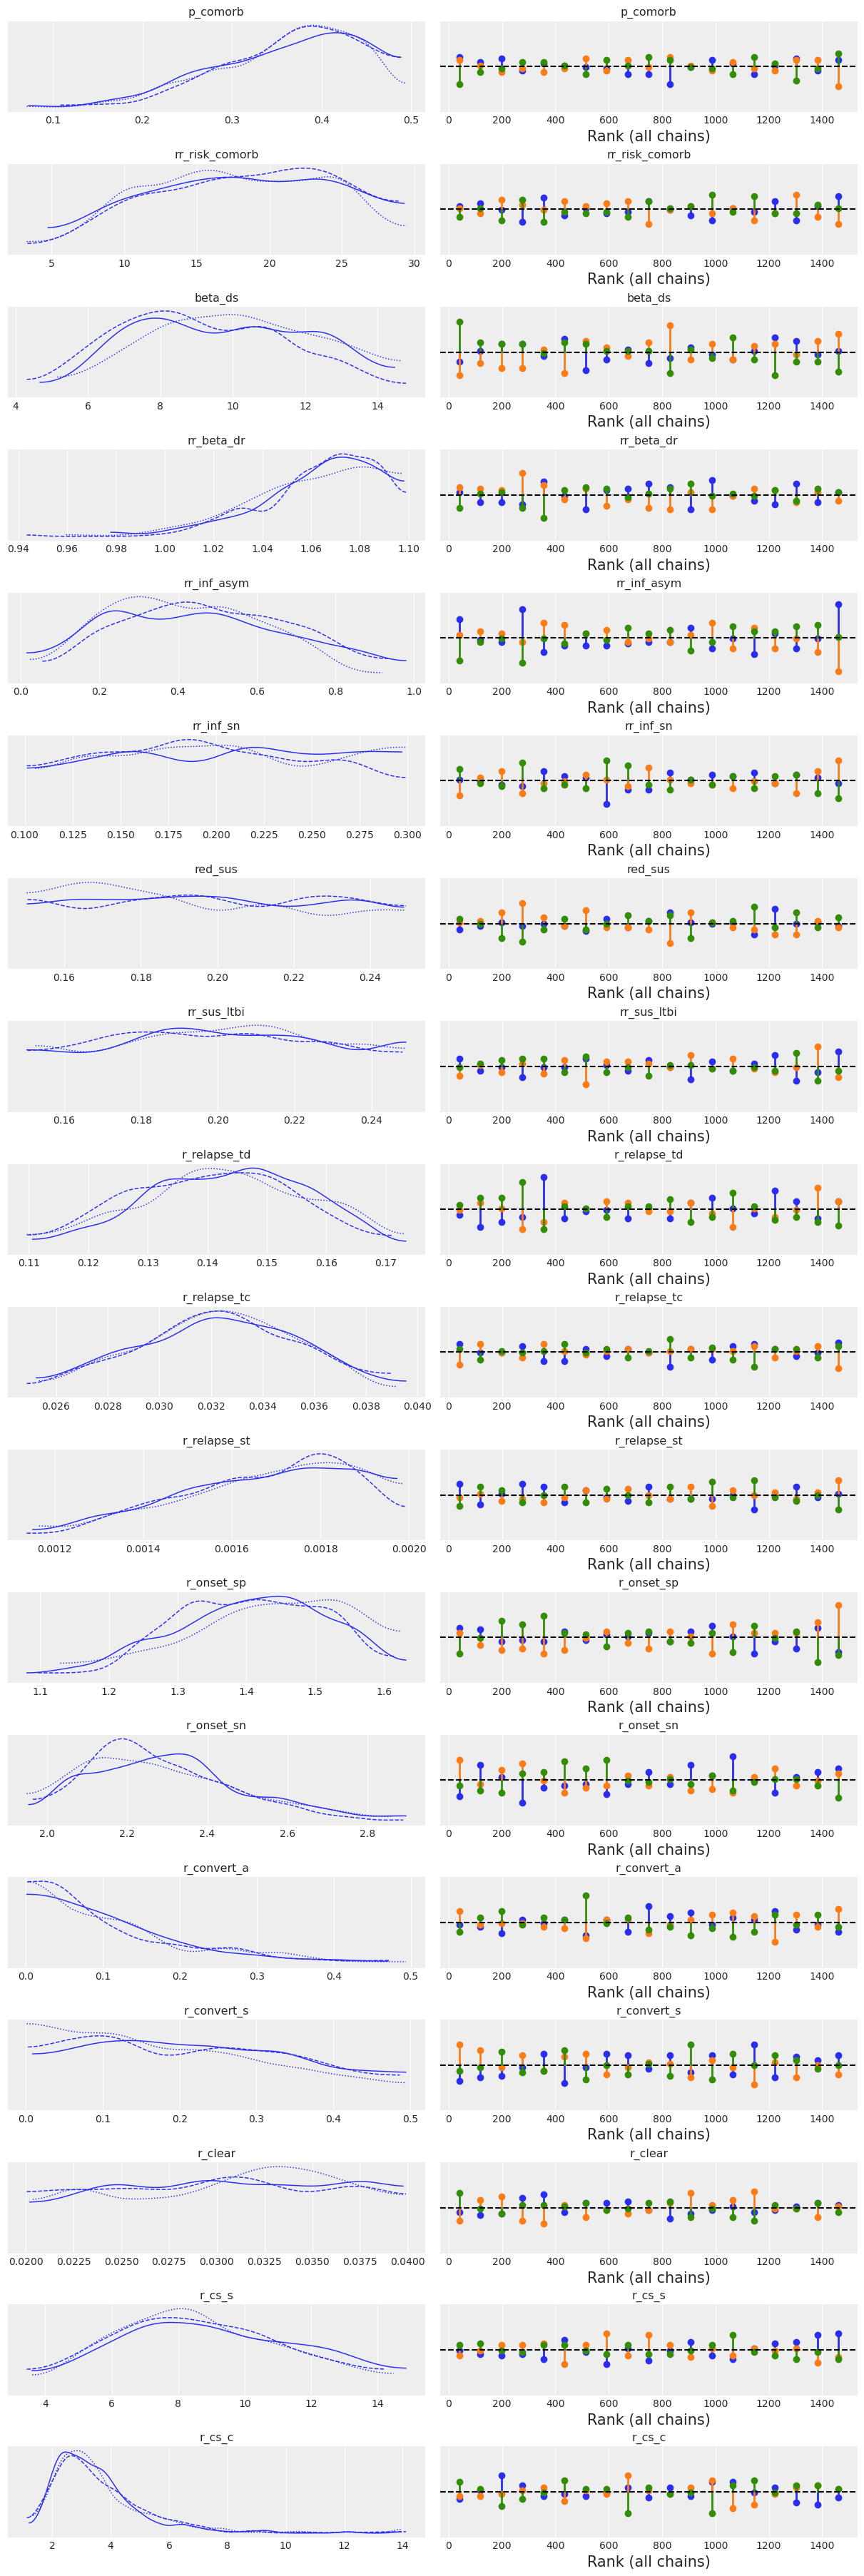

In [7]:
az.plot_trace(fit, kind="rank_vlines")

In [8]:
posts = post_to_particles(fit)
posts = [src.serve(post) for post in posts]

with open(f'{out_path}/Post.json', 'w') as f:
    json.dump(posts, f)
    
    
fit.to_netcdf(f'{out_path}/Post.nc')
ppost.to_netcdf(f'{out_path}/Targets_Post.nc')

'out/dy_free/Targets_Post.nc'

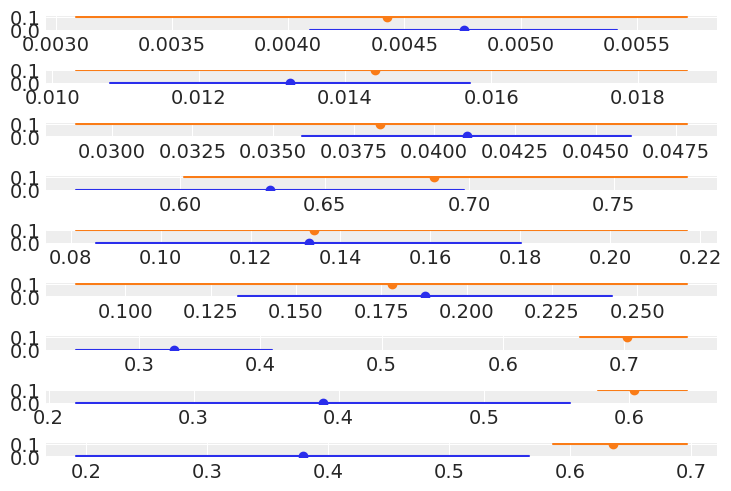

In [9]:
obs, eps = src.Obs, src.Eps

fig, ax = plt.subplots(nrows=9)


m = np.mean(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 1)
l = np.quantile(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 0.025, 1)
u = np.quantile(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 0.975, 1)

for i in range(9):
    ax[i].scatter(obs[i], 0)
    ax[i].plot([obs[i] - eps[i], obs[i] + eps[i]], [0, 0] )
    
    ax[i].scatter(m[i], 0.1)
    ax[i].plot([l[i], u[i]], [0.1, 0.1] )